In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
def load_data(train_batch_size=64, test_batch_size=1000):
    """
    Load and preprocess the MNIST dataset.

    Parameters:
    - train_batch_size (int): Batch size for training data.
    - test_batch_size (int): Batch size for test data.

    Returns:
    - tuple: Containing training and test data loaders.
    """
    # Define common transformations
    common_transforms = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Fetch and load training data
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='data', train=True, download=True, transform=common_transforms),
        batch_size=train_batch_size, shuffle=True)

    # Fetch and load test data
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='data', train=False, transform=common_transforms),
        batch_size=test_batch_size, shuffle=True)

    return train_loader, test_loader


In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),  # Assuming input images are 32x32
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc_layers(x)
        return x


In [4]:
class CNN(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=dropout_prob),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=dropout_prob)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(1024, 256),  # Update this based on your input size calculation
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [5]:
train_batch_size = 64
test_batch_size = 1000
train_loader, test_loader = load_data(train_batch_size, test_batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 77653986.19it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37961671.52it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24036713.90it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10490379.28it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
def train(model, optimizer, epoch, train_loader, log_interval):
    model.train()  # Set the model to training mode
    loss_fn = torch.nn.CrossEntropyLoss()
    total_correct = 0
    total_loss = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Reset gradients for each batch

        # Forward pass
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Aggregate the loss

        # Calculate accuracy
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        total_correct += (predicted == target).sum().item()

        # Logging
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    average_loss = total_loss / len(train_loader)
    accuracy = 100. * total_correct / total_samples
    print(f"Training Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return average_loss, accuracy


In [8]:
def test(model, epoch, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0

    loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss

            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set, Epoch {epoch}, Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')


In [10]:
torch.manual_seed(1)
model= LeNet()

lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model.parameters(), lr, momentum)
m0_loss_arr = []
m0_acc_arr = []

epochs = 10
log_interval = 200
for epoch in range(1, epochs + 1):
    loss, acc = train(model, optimizer, epoch, train_loader, log_interval)
    m0_loss_arr.append(loss)
    m0_acc_arr.append(acc)
    test(model, epoch, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322258
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.386213
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.317166
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.253307
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.247413
Training Loss: 0.5748, Accuracy: 81.59%

Test set, Epoch 1, Average loss: 0.1374, Accuracy: 9592/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.158090
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.139174
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.365055
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.091991
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.108601
Training Loss: 0.1219, Accuracy: 96.26%

Test set, Epoch 2, Average loss: 0.0790, Accuracy: 9757/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.027724
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.080616
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.040897
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.037093
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.076086
Training Loss: 0.0820, Accuracy: 97.45%

Test

In [11]:
torch.manual_seed(1)

model_1= CNN()

lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model_1.parameters(), lr=lr, momentum=momentum)
m1_loss_arr = []
m1_acc_arr = []

epochs = 10
log_interval = 100
for epoch in range(1, epochs + 1):
    loss, acc = train(model_1, optimizer, epoch, train_loader, log_interval=log_interval)
    m1_loss_arr.append(loss)
    m1_acc_arr.append(acc)
    test(model_1, epoch, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315159
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.534601
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.927839
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.393550
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.398120
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.287560
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.377310
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.299902
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.276705
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.486123
Training Loss: 0.6236, Accuracy: 79.22%

Test set, Epoch 1, Average loss: 0.1211, Accuracy: 9627/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.278387
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.218564
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.162312
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.185027
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.157917
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.142425
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.311090
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.296116
Tr

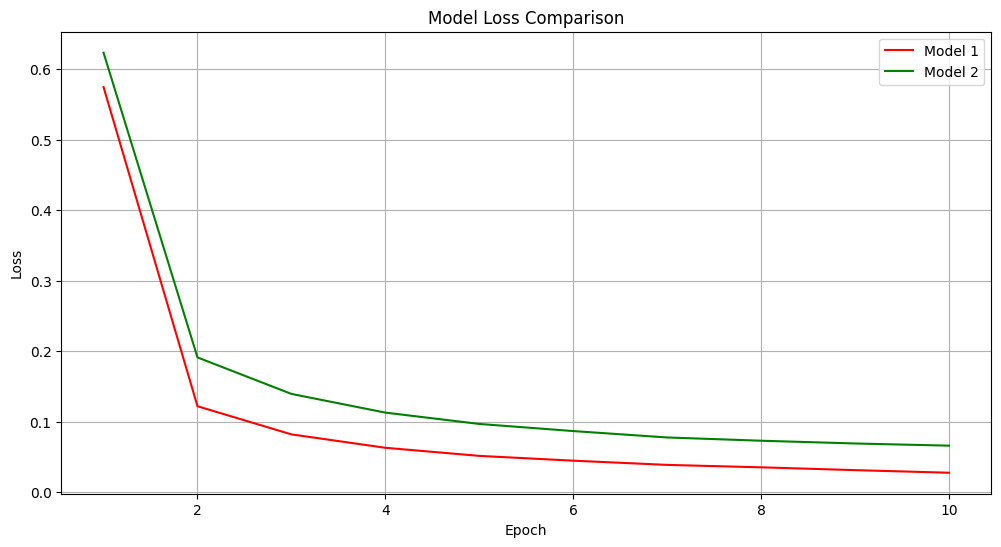

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(m0_loss_arr) + 1), m0_loss_arr, color="r", label="Model 1")
plt.plot(np.arange(1, len(m1_loss_arr) + 1), m1_loss_arr, color="g", label="Model 2")
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


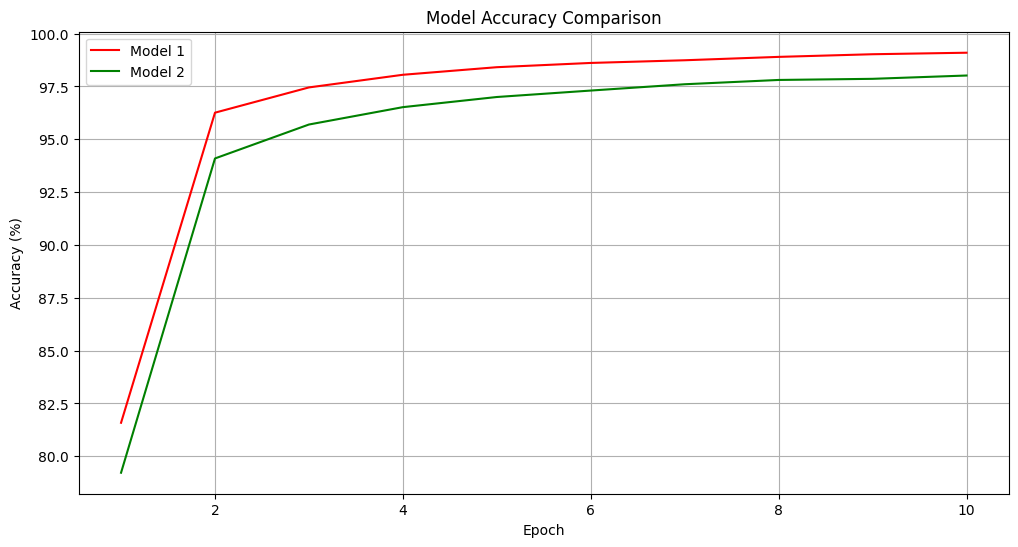

In [15]:
plt.figure(figsize=(12, 6))
epochs_range = np.arange(1, len(m0_acc_arr) + 1)
plt.plot(epochs_range, m0_acc_arr, color="r", label="Model 1")
plt.plot(epochs_range, m1_acc_arr, color="g", label="Model 2")
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')  # Assuming accuracy is in percentage
plt.legend(loc="upper left")
plt.grid(True)  # Adding a grid for better readability
plt.show()
